In [126]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import optimize

In [127]:
p_s = 100000 #Pa
p_t = 10000 #Pa
n_lev = 60
p = np.linspace(p_s,p_t,n_lev)
#p = np.logspace(5,4,n_lev)

In [128]:
cp_air = 1000 #J kg-1 K-1
g = 10 #m s-2
Ra = 287 #J kg-1 K-1 air
Rv = 461 #J kg-1 K-1 water vapor
Lv = 2.3E6 #J kg-1
eps = Ra/Rv #dimensionless
p_rad = 1E5 #Pa, reference pressure for absorption cross sections
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K

lapse_dry = -g/cp_air #K/m

In [129]:
def w_sat_p(T): #Pa
    e_sat = e_sat_ref * np.exp(-Lv/Rv*(1/T-1/T_ref))
    return e_sat

def w_sat_mix(T,p): #kg/kg
    r_sat = eps*w_sat_p(T)/p
    return r_sat

def height(p,T): #m
    rho = p/(Ra*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def water_mass(energy):#kg m-2
    mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv * mass_atm
    return mass_w

In [130]:
def MALR(T,p): #dlnT/dlnp
    r_sat = w_sat_mix(T,p)
    A = (Lv*r_sat)/(Ra*T)
    B = (Lv**2*r_sat)/(cp_air*Ra*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_s,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_s
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Ra/g * lapse_z
    return l_p


def T_atm_z(T_s,z,lapse_z):
    Temp = T_s + z*lapse_z
    return Temp

def T_atm_p(T_s,p,lapse_p):
    Temp = T_s * (p/p_s)**(lapse_p)
    return Temp

In [131]:
def TE(T): #J kg-1
    energy = integrate.trapezoid(-cp_air*T/g,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def DSE(T,z): #J kg-1
    energy = integrate.trapezoid(-cp_air*T/g-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def PE(z):
    energy = integrate.trapezoid(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def TE_moist_opt(T_s): #the pressure array is external, meaning is not an optimisation parameter (i.e., won't be changed) 
    T_moist = T_MA(T_s,p)
    thermal_energy = TE(T_moist)
    return thermal_energy

def DSE_moist_opt(T_s):
    T_moist = T_MA(T_s,p)
    z_moist = height(p,T_moist)
    dry_static_energy = DSE(T_moist,z_moist)
    return dry_static_energy

def T_surface_TE(thermal_energy): #find T_surface conserving thermal energy
    def fun(x):
        res = TE_moist_opt(x)-thermal_energy
        return res
        
    T_surface = optimize.root_scalar(fun, bracket=[200,400])
    return T_surface.root

def T_surface_DSE(dry_static_energy): #find T_surface conserving dry static energy
    def fun(x):
        res = DSE_moist_opt(x)-dry_static_energy
        return res
        
    T_surface = optimize.root_scalar(fun,bracket=[200,400])
    return T_surface.root

In [132]:
#check Koll et al. (2023) for the constants

def k_wv_line(nu,p):
    
    k_rot = 165 #m2 kg-1
    nu_rot = 150 #cm-1
    l_rot = 55 #cm-1
    
    k_vr = 15 #m2 kg-1
    nu_vr = 1500 #cm-1
    l_vr = 38 + 38*np.heaviside(nu-nu_vr,0.5) #cm-1

    rot = k_rot*np.exp(-abs(nu-nu_rot)/l_rot)
    vibrot = k_vr*np.exp(-abs(nu-nu_vr)/l_vr)

    cross_section = np.maximum(rot,vibrot)*p/p_rad

    return cross_section

def k_wv_cont_e(e_wv,T):

    k_cnt = 3E-3 #m2 kg-1
    a = 7 #dimensionless
    
    cross_section = k_cnt*e_wv/e_sat_ref*(T/T_ref)**(-a)

    return cross_section

def k_wv_cont_RH(RH,T):

    k_cnt = 3E-3 #m2 kg-1
    a = 7 #dimensionless
    e_wv = RH*w_sat_p(T)
    
    cross_section = k_cnt*e_wv/e_sat_ref*(T/T_ref)**(-a)

    return cross_section
    
def k_co2(nu,p):

    k0 = 500 #m2 kg-1
    nu0 = 667.5 #cm-1
    l0 = 10.2 #cm-1

    cross_section = k0*np.exp(-abs(nu-nu0)/l0)*p/p_rad

    return cross_section
    

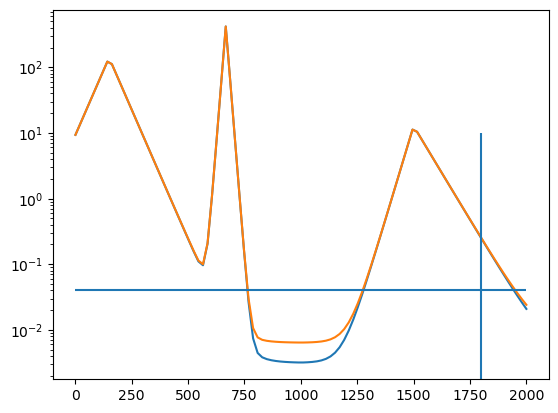

[1.00000000e+04 4.71877979e+02 2.41640225e+02 1.62401575e+02
 1.22297715e+02 9.80780662e+01 8.18655420e+01 7.02526256e+01
 6.15250761e+01 5.47263682e+01 4.92807009e+01 4.48207171e+01
 4.11010088e+01 3.79513916e+01 3.52501335e+01 3.29078580e+01
 3.08574635e+01 2.90475911e+01 2.74382639e+01 2.59978992e+01
 2.47012151e+01 2.35277342e+01 2.24606938e+01 2.14862401e+01
 2.05928237e+01 1.97707393e+01 1.90117719e+01 1.83089214e+01
 1.76561859e+01 1.70483899e+01 1.64810468e+01 1.59502481e+01
 1.54525731e+01 1.49850150e+01 1.45449203e+01 1.41299383e+01
 1.37379793e+01 1.33671789e+01 1.30158688e+01 1.26825519e+01
 1.23658802e+01 1.20646372e+01 1.17777223e+01 1.15041368e+01
 1.12429731e+01 1.09934040e+01 1.07546739e+01 1.05260919e+01
 1.03070244e+01 1.00968893e+01 9.89515138e+00 9.70131703e+00
 9.51493075e+00 9.33557136e+00 9.16284881e+00 8.99640144e+00
 8.83589336e+00 8.68101226e+00 8.53146733e+00 8.38698746e+00
 8.24731962e+00 8.11222734e+00 7.98148939e+00 7.85489860e+00
 7.73226071e+00 7.613393

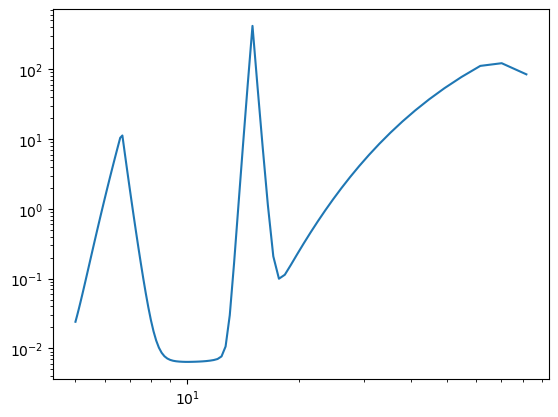

In [133]:
nu = np.linspace(1,2000,100)
pres = 850E2
kl = k_wv_line(nu,pres)

T = 280
e_wv = 0.8*w_sat_p(T)

kc = k_wv_cont_e(e_wv,T)

kco2 = k_co2(nu,pres)

k = kl+kc+kco2

plt.plot(nu,k)
pres = 850E2
kl = k_wv_line(nu,pres)

T = 300
e_wv = 0.8*w_sat_p(T)

kc = k_wv_cont_e(e_wv,T)

kco2 = k_co2(nu,pres)

k = kl+kc+kco2

plt.plot(nu,k)
plt.yscale('log')
plt.hlines(4E-2,1,2000)
plt.vlines(1800,1E-3,10)
plt.show()

print(1/nu*1E4)
plt.plot(1/nu[6:]*1E4,k[6:])
plt.yscale('log')
plt.xscale('log')
plt.show()

[100000.          98474.57627119  96949.15254237  95423.72881356
  93898.30508475  92372.88135593  90847.45762712  89322.03389831
  87796.61016949  86271.18644068  84745.76271186  83220.33898305
  81694.91525424  80169.49152542  78644.06779661  77118.6440678
  75593.22033898  74067.79661017  72542.37288136  71016.94915254
  69491.52542373  67966.10169492  66440.6779661   64915.25423729
  63389.83050847  61864.40677966  60338.98305085  58813.55932203
  57288.13559322  55762.71186441  54237.28813559  52711.86440678
  51186.44067797  49661.01694915  48135.59322034  46610.16949153
  45084.74576271  43559.3220339   42033.89830508  40508.47457627
  38983.05084746  37457.62711864  35932.20338983  34406.77966102
  32881.3559322   31355.93220339  29830.50847458  28305.08474576
  26779.66101695  25254.23728814  23728.81355932  22203.38983051
  20677.96610169  19152.54237288  17627.11864407  16101.69491525
  14576.27118644  13050.84745763  11525.42372881  10000.        ]


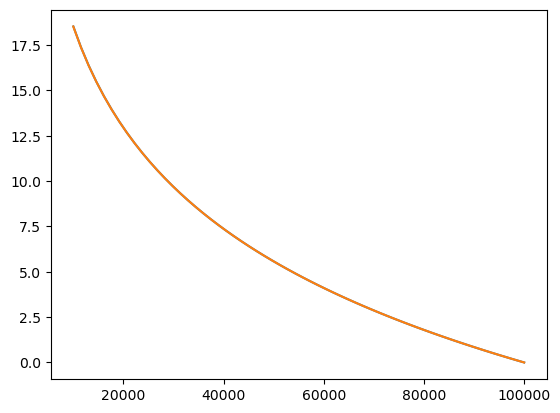

In [134]:
T = np.ones((n_lev))*280
z = height(p,T)

print(p)

plt.plot(p,z/1000)
plt.plot(p_s*np.exp(-g*z/(Ra*280)),z/1000)
plt.show()

274.9869296142389
275.08925575201704
dry static energy differences between moistTE and dry - conserving TE and DSE, resp.
-179.9069430246018
-1.1641532182693481e-10
thermal energy differences between moistTE and dry - conserving TE and DSE, resp.
5.820766091346741e-11
148.61090561028686


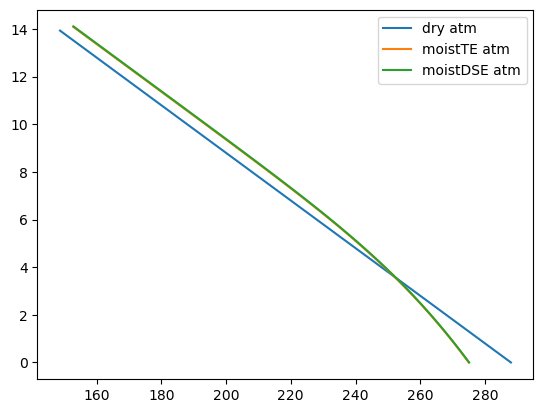

In [135]:
T_s = 288

lapse_p = lapse_pressure(lapse_dry)
T = T_atm_p(288,p,lapse_p)
z = height(p,T)

T_sTE = T_surface_TE(TE(T))

print(T_sTE)

T_moistTE = T_MA(T_sTE,p)
z_moistTE = height(p,T_moistTE)


T_sDSE = T_surface_DSE(DSE(T,z))

print(T_sDSE)

T_moistDSE = T_MA(T_sDSE,p)
z_moistDSE = height(p,T_moistDSE)


T_eq = TE(T_moistTE)/(cp_air)
T_iso = np.ones((n_lev))*T_eq
z_iso = height(p,T_iso)

TE_diff = TE(T_moistTE)-TE(T)
TE_diff2 = TE(T_moistDSE)-TE(T)
DSE_diff = DSE(T_moistTE,z_moistTE)-DSE(T,z)
DSE_diff2 = DSE(T_moistDSE,z_moistDSE)-DSE(T,z)
print('dry static energy differences between moistTE and dry - conserving TE and DSE, resp.')
print(DSE_diff)
print(DSE_diff2)
print('thermal energy differences between moistTE and dry - conserving TE and DSE, resp.')
print(TE_diff)
print(TE_diff2)


plt.plot(T,z/1000, label = 'dry atm')
plt.plot(T_moistTE,z_moistTE/1000, label = 'moistTE atm')
plt.plot(T_moistDSE,z_moistDSE/1000, label = 'moistDSE atm')
plt.legend()
plt.show()